# Final Project

In [211]:
# import libraries (notice that we have included some new libraries that we will be using in this lab)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import datetime
from numbers import Number

In [212]:
stationName = "Vancouver Harbour" # Vancouver Harbour # Tofino

van_slev_file_name = 'data/VanHarbourSeaLevelData.csv'
van_temperature_file_name = 'data/VanHarbourTempData.csv'
tofino_slev_file_name = 'data/TofinoSeaLevelData.csv'
tofino_temperature_file_name = 'data/TofinoTempData.csv'

In [213]:
# Make dataframe for each day for the period of 1940-2021 for Vancouver Harbour and Tofino

start_date = "1940-01-01"
end_date = "2021-12-31"

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df_SOB_van = pd.DataFrame(date_range, columns=['Date'])
df_SOB_tofino = pd.DataFrame(date_range, columns=['Date'])


In [214]:
# Read in the Vancouver Harbour Data 
df_van_slev = pd.read_csv(van_slev_file_name, sep=',', parse_dates=['Date'])
df_van_slev = df_van_slev.set_index('Date')

df_van_temp = pd.read_csv(van_temperature_file_name, sep=',', parse_dates=['Date'])
df_van_temp = df_van_temp.set_index('Date')
# drop columns other than date and MeanTemp
df_van_temp = df_van_temp.drop(columns=['Unnamed: 0', 'Year', 'Month', 'Day', 'MaxTemp', 'MaxTempFlag',
       'MinTemp', 'MinTempFlag', 'MeanTempFlag', 'HeatDegDays',
       'HeatDegDaysFlag', 'CoolDegDays', 'CoolDegDaysFlag'])


In [215]:
# Add the data to the SOB dataframe if the date matches
df_SOB_van = df_SOB_van.merge(df_van_slev, how='left', on='Date')
df_SOB_van = df_SOB_van.merge(df_van_temp, how='left', on='Date')

df_SOB_tofino = df_SOB_tofino.merge(df_van_slev, how='left', on='Date')
df_SOB_tofino = df_SOB_tofino.merge(df_van_temp, how='left', on='Date')

In [216]:
# Plot the time series for the data
def plot_daily_time_series(df, x_name, y_name, title, xlabel, ylabel):
    plt.figure(figsize=(15, 5))
    plt.plot(df[x_name], df[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot monthly time series
def plot_monthly_time_series(df, x_name, y_name, title, xlabel, ylabel):
    df_monthly = df.groupby(pd.Grouper(key=x_name, freq='M')).mean()
    plt.figure(figsize=(15, 5))
    plt.plot(df_monthly.index, df_monthly[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot Yearly time series
def plot_yearly_time_series(df, x_name, y_name, title, xlabel, ylabel):
    df_yearly = df.groupby(pd.Grouper(key=x_name, freq='Y')).mean()
    plt.figure(figsize=(15, 5))
    plt.plot(df_yearly.index, df_yearly[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [217]:

def find_seasonal_cycle(df, x_name, y_name, title, xlabel, ylabel):
    # Group by month and calculate mean, max, min, and std for each month
    df_monthly = df.groupby(df[x_name].dt.month).agg({y_name: ['mean', 'max', 'min', 'std']}).reset_index()

    # Rename columns and convert month number to month name
    df_monthly.columns = ['Month', 'Mean', 'Max', 'Min', 'Std']
    df_monthly['Month'] = df_monthly['Month'].apply(lambda x: datetime.date(1900, x, 1).strftime('%B'))

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_monthly['Month'], df_monthly['Mean'], marker='s', label='Mean')
    plt.plot(df_monthly['Month'], df_monthly['Min'], ':', color='black', label='_nolegend_')
    plt.plot(df_monthly['Month'], df_monthly['Max'], ':', color='black', label='Max & Min')
    plt.plot(df_monthly['Month'], df_monthly['Mean'] + df_monthly['Std'], '--', color='red', label='Mean +/- Std')
    plt.plot(df_monthly['Month'], df_monthly['Mean'] - df_monthly['Std'], '--', color='red', label='_nolegend_')
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Show the plot
    plt.show()
    return df_monthly

In [218]:
def plot_data_anomaly(df, x, y, title, xlabel, ylabel, cycle):
    df_monthly = df.groupby(pd.Grouper(key=x, freq='M')).mean()
    tiled_data = np.tile(cycle, 82)
    anomaly = df_monthly[y] - tiled_data
    plt.figure(figsize=(15, 5))
    plt.plot(df_monthly.index, anomaly, '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return anomaly


In [219]:
def plot_correlation(x, y, title, xlabel, ylabel):

    x = x.values.reshape(-1,1) # reshape the data to be 2D
    y = y.values.reshape(-1,1)
    
    mask = np.isnan(x) | np.isnan(y) # create a mask for NaN values
    x = x[~mask] # drop the NaN values
    y = y[~mask]

    x = x.reshape(-1,1) # reshape array again?
    y = y.reshape(-1,1)
    model = LinearRegression() # create the model
    model.fit(x, y) # fit the model
    ypred = model.predict(x) # make predictions
    # plot on the same figure

    # The coefficients
    print('Coefficients: \', model.coef_')
    # The mean squared error
    # print r^2 value
    print('R^2: ', r2_score(y, ypred))

    plt.figure(figsize=(20,5))
    plt.scatter(x, y)
    plt.plot(x, ypred, color='red')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)






In [220]:
def plot_all(df, stationName):
    plot_daily_time_series(df, 'Date', 'sealevel', 'Daily Sea Level at ' + stationName + '(1940-2022)', 'Date', 'Sea Level (m)')
    plot_daily_time_series(df, 'Date', 'MeanTemp', 'Daily Mean Temperature at ' + stationName + '(1940-2022)', 'Date', 'Mean Temperature (C)')
    plot_monthly_time_series(df, 'Date', 'sealevel', 'Monthly Sea Level at ' + stationName + '(1940-2022)', 'Date', 'Sea Level (m)')
    plot_monthly_time_series(df, 'Date', 'MeanTemp', 'Monthly Mean Temperature at ' + stationName + '(1940-2022)', 'Date', 'Mean Temperature (C)')
    plot_yearly_time_series(df, 'Date', 'sealevel', 'Yearly Sea Level at ' + stationName + '(1940-2022)', 'Date', 'Sea Level (m)')
    plot_yearly_time_series(df, 'Date', 'MeanTemp', 'Yearly Mean Temperature at ' + stationName + '(1940-2022)', 'Date', 'Mean Temperature (C)')

    slev_cycle_van = find_seasonal_cycle(df, 'Date', 'sealevel', 'Seasonal Cycle of Sea Level at ' + stationName, 'Month', 'Sea Level (m)')
    temp_cycle_van = find_seasonal_cycle(df, 'Date', 'MeanTemp', 'Seasonal Cycle of Mean Temperature at ' + stationName, 'Month', 'Mean Temperature (C)')

    slev_anomaly = plot_data_anomaly(df, 'Date', 'sealevel', 'Sea Level Anomaly at ' + stationName + '(1940-2022)', 'Date', 'Sea Level Anomaly (m)', slev_cycle_van['Mean'].values)
    temp_anomaly = plot_data_anomaly(df, 'Date', 'MeanTemp', 'Temperature Anomaly at ' + stationName + '(1940-2022)', 'Date', 'Temperature Anomaly (C)', temp_cycle_van['Mean'].values)

    plot_correlation(temp_anomaly, slev_anomaly, 'Sea Level Anomaly vs Temperature Anomaly at ' + stationName + '(1940-2021)', 'Temperature Anomaly [˚C]', 'Sea Level Anomaly [m]')


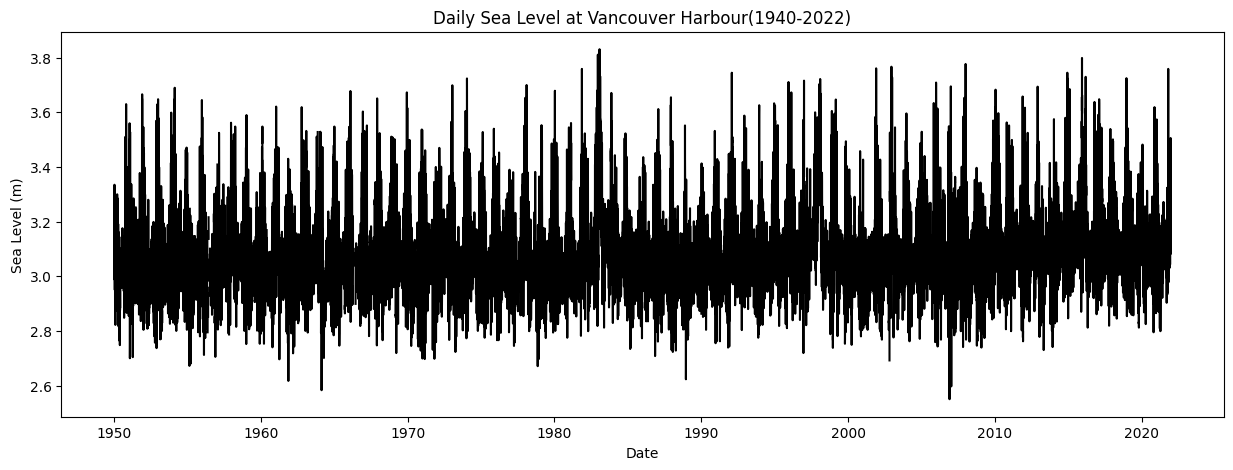

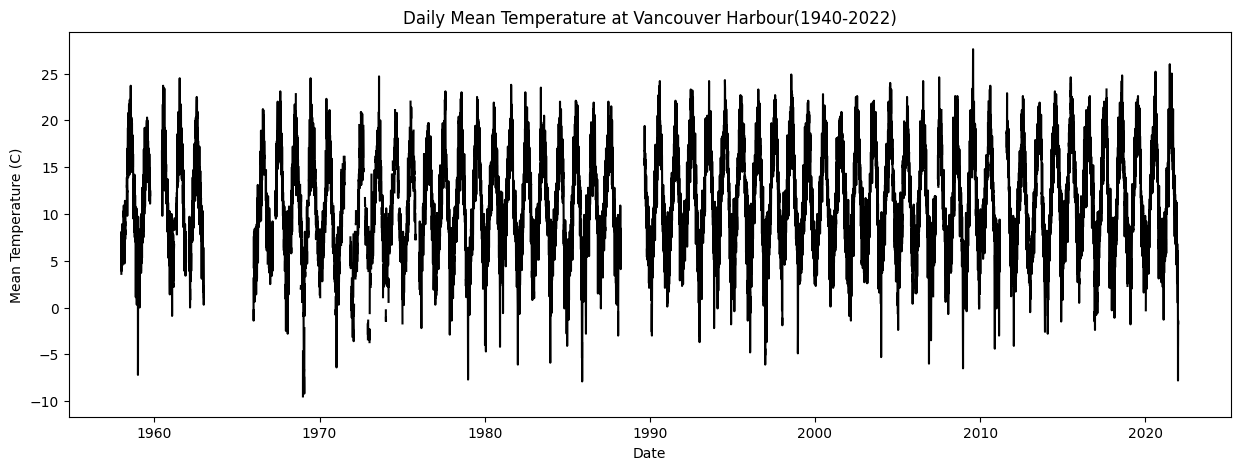

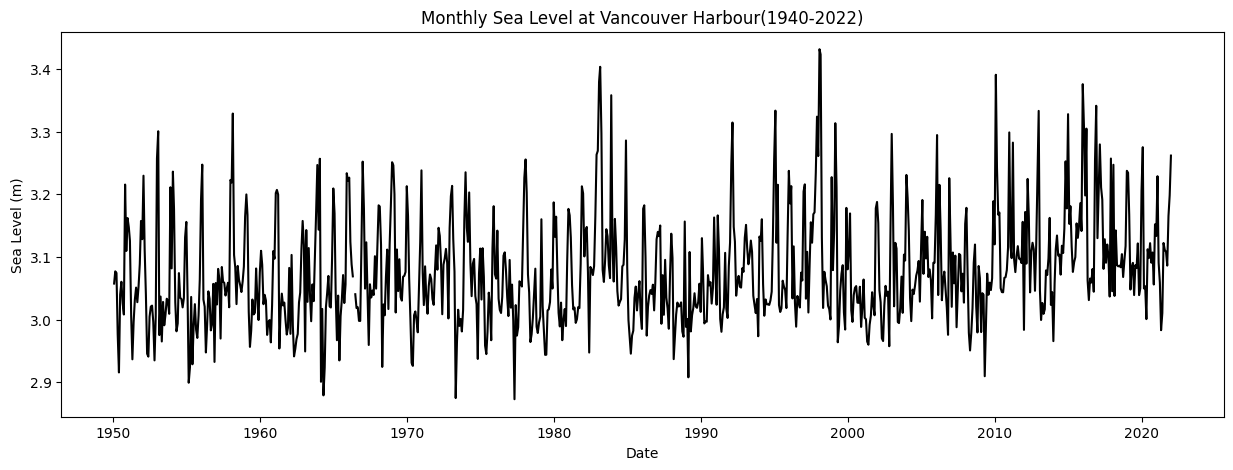

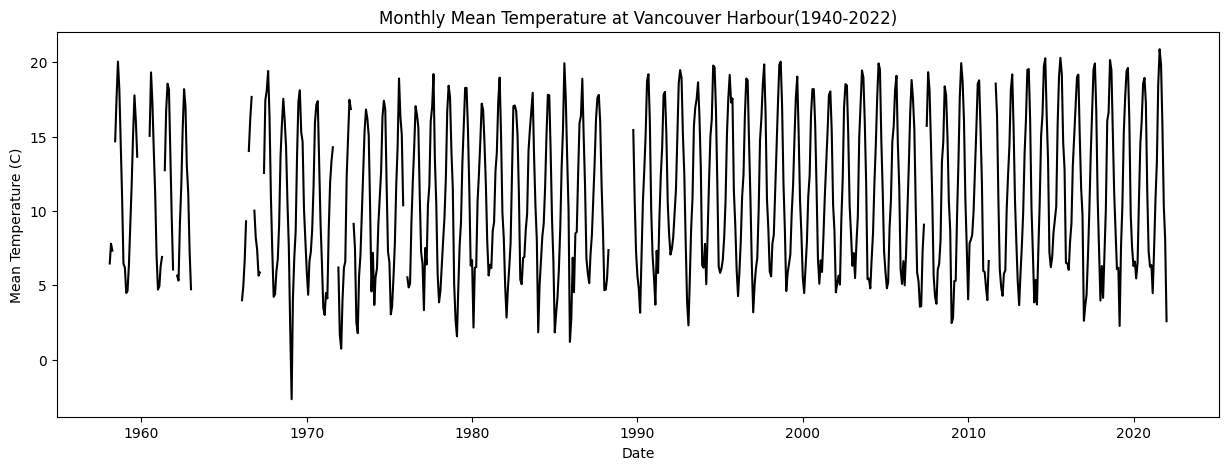

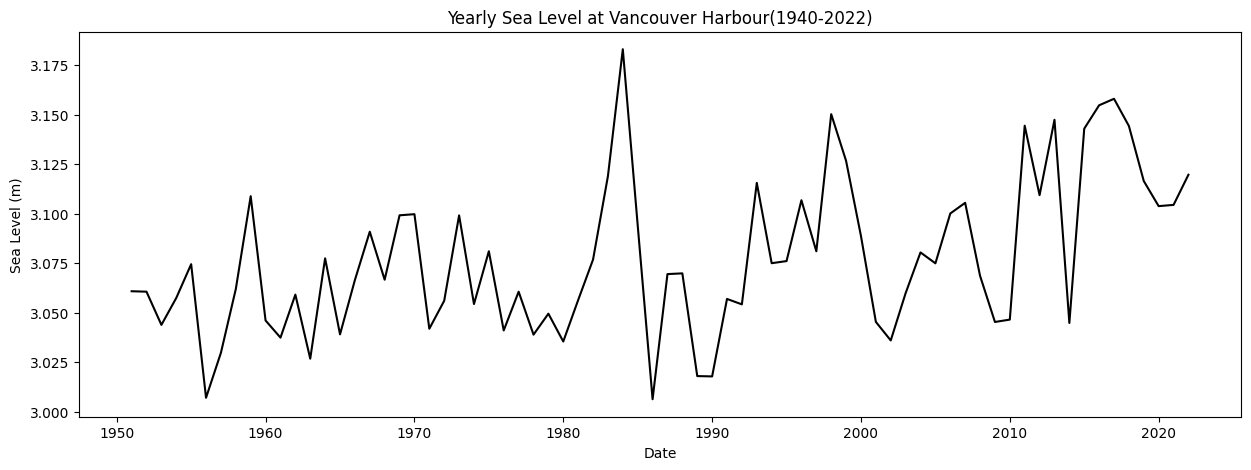

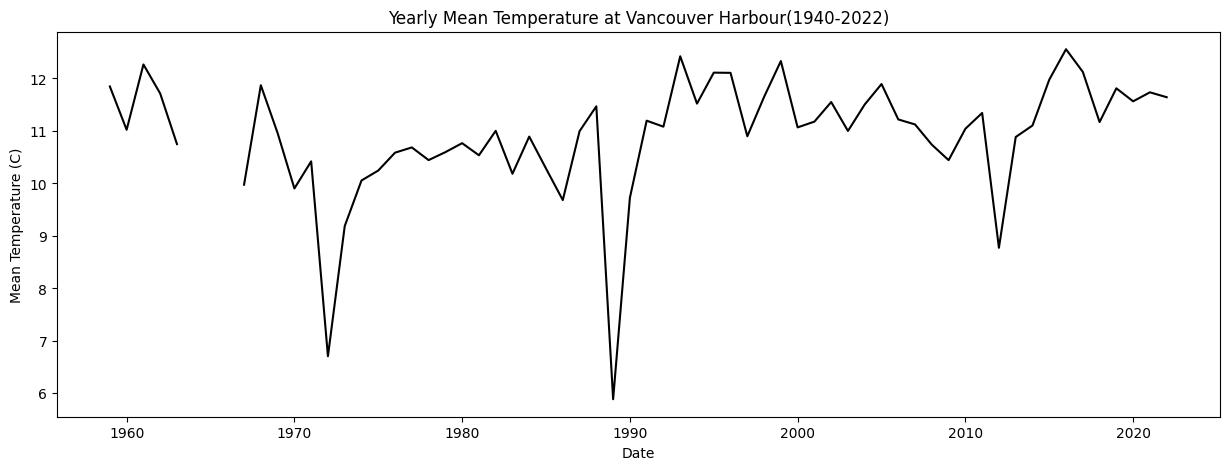

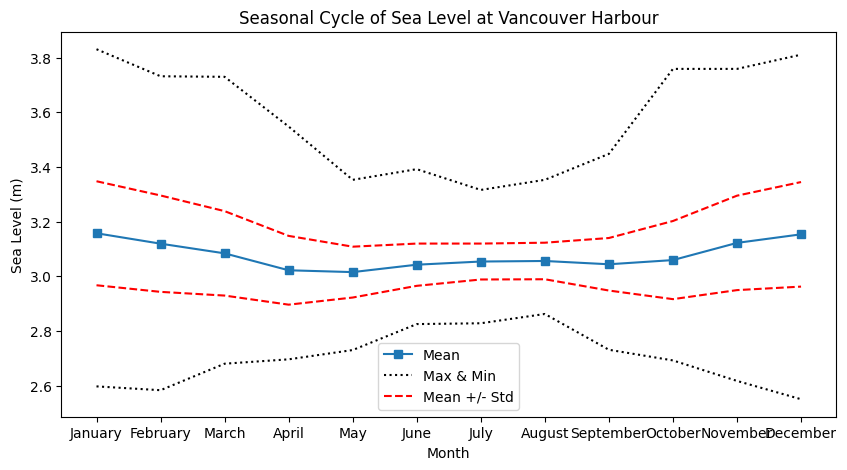

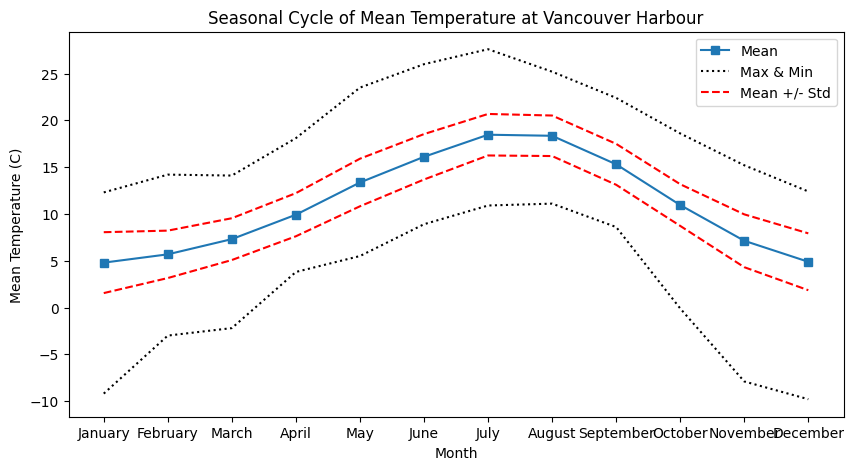

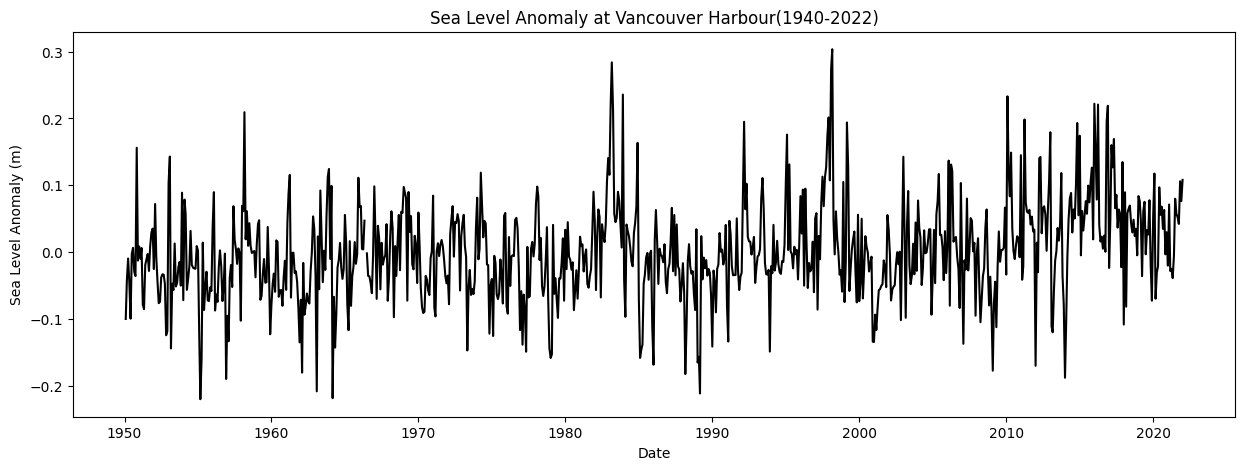

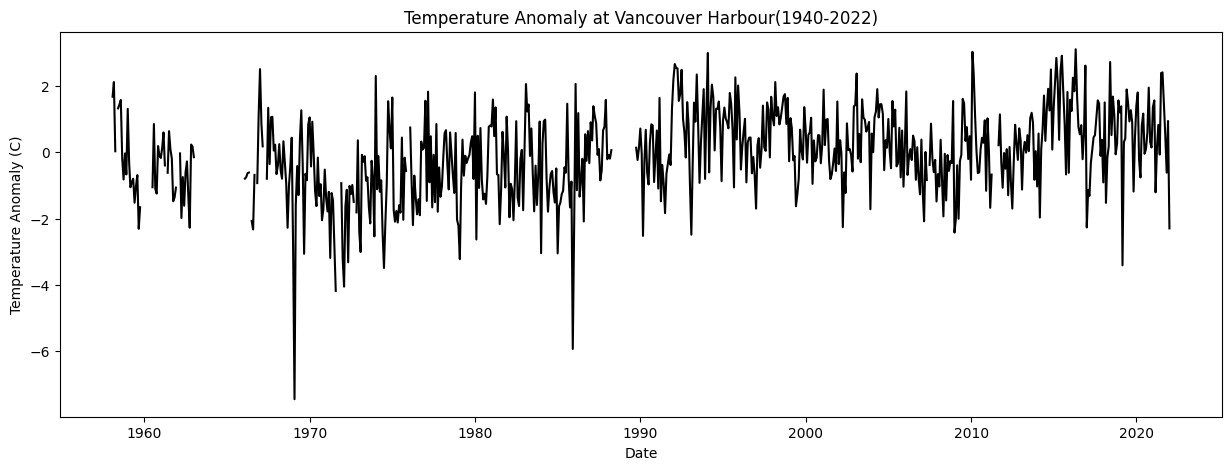

Coefficients: ', model.coef_
R^2:  0.09982647956211865


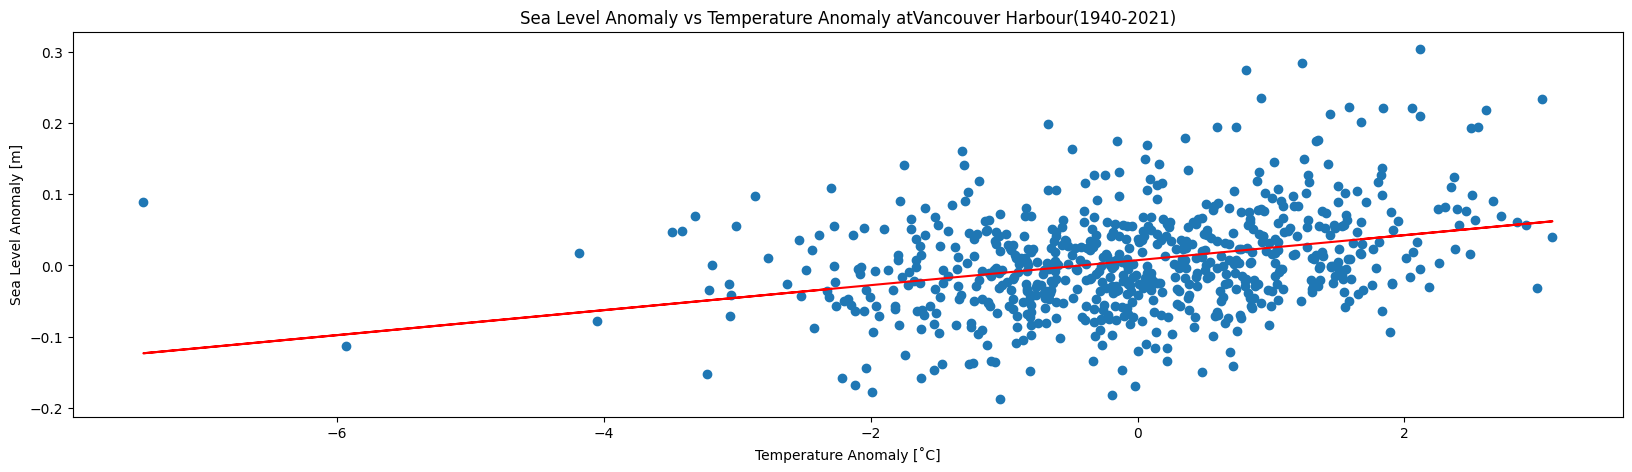

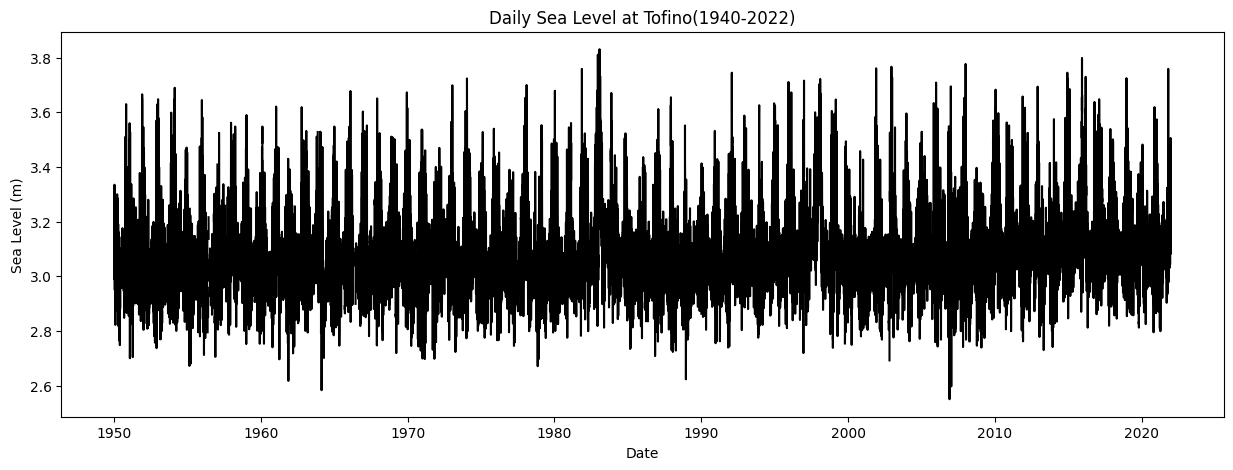

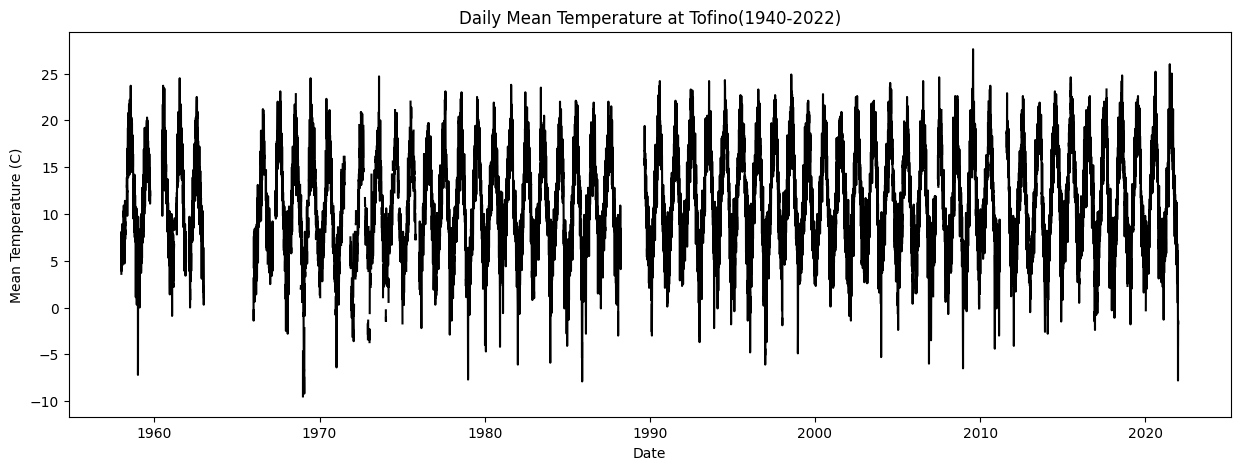

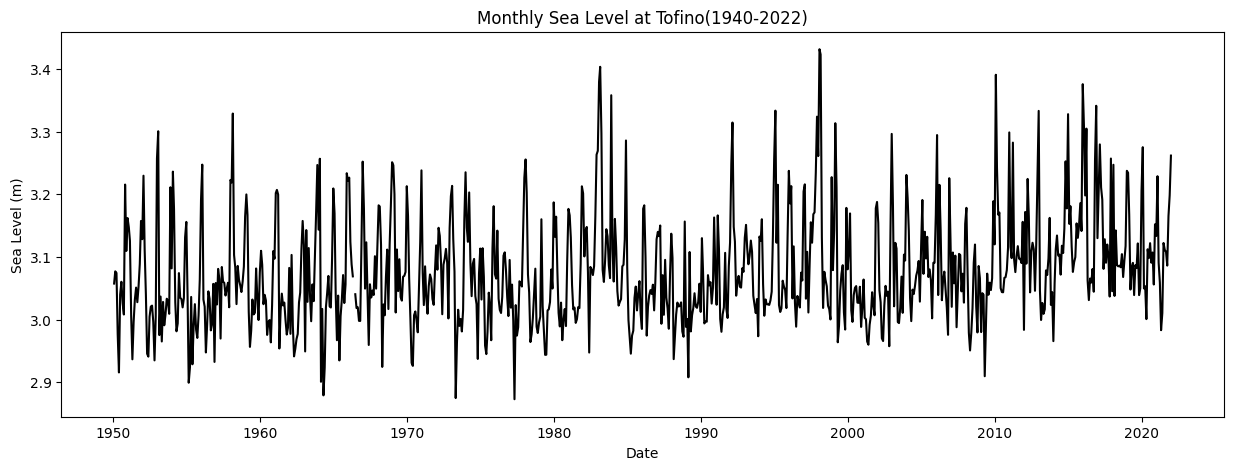

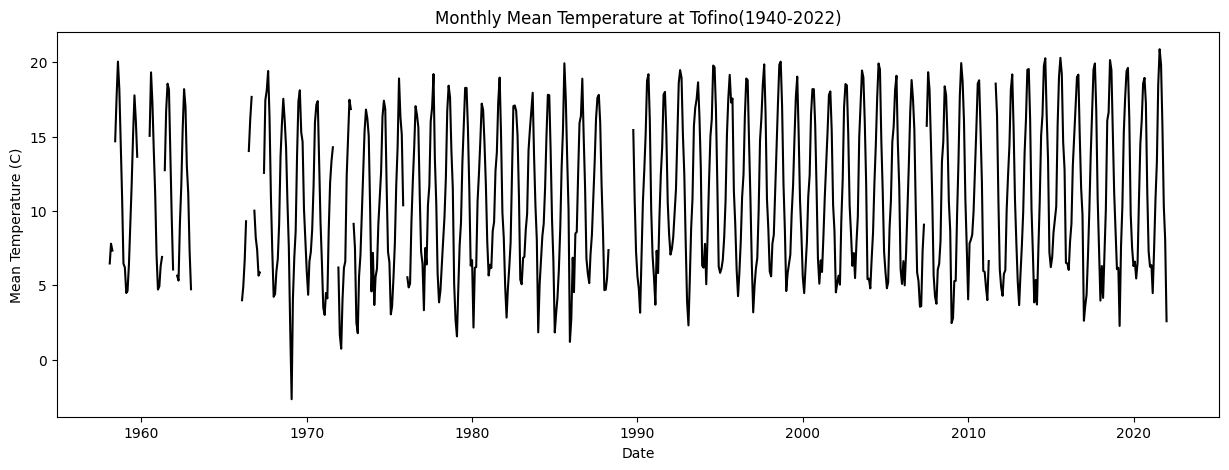

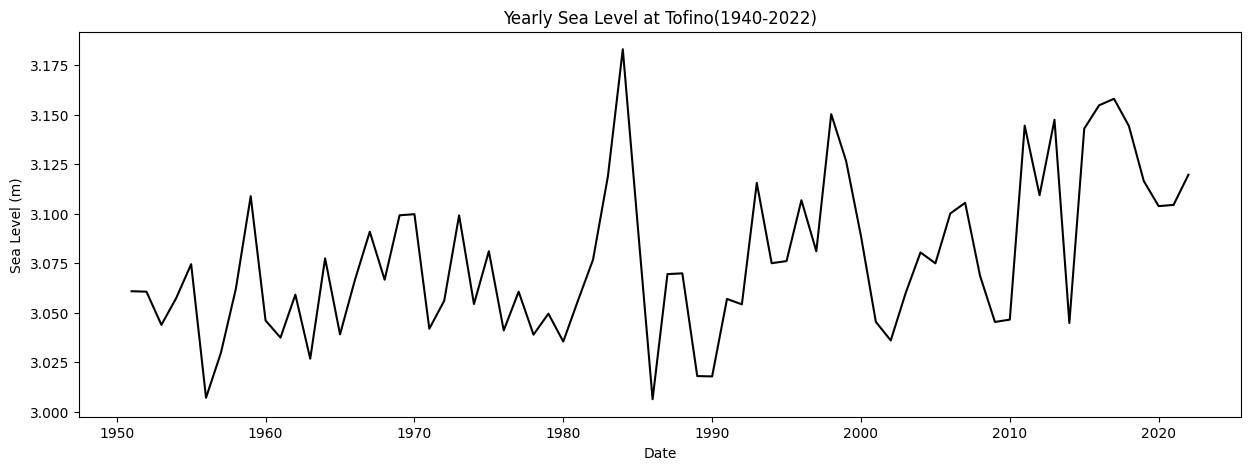

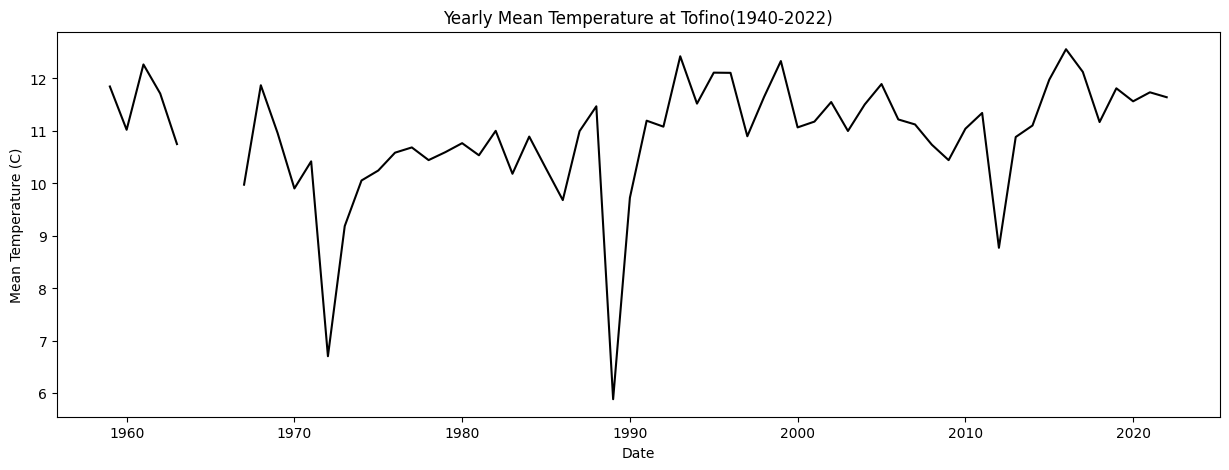

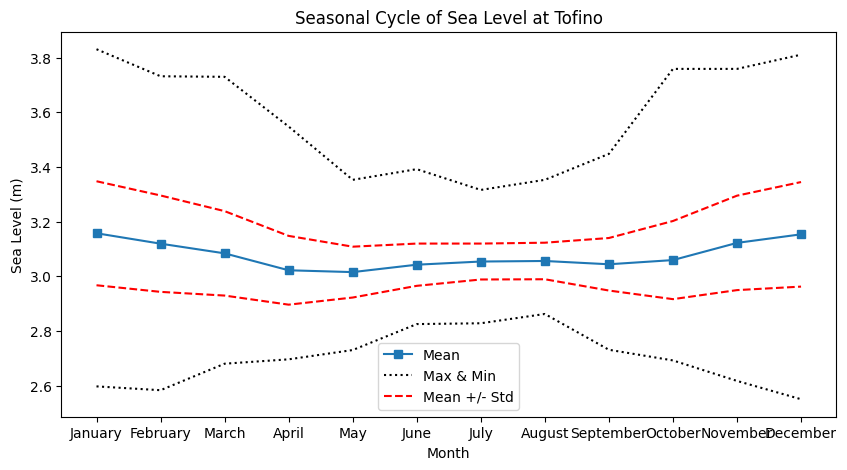

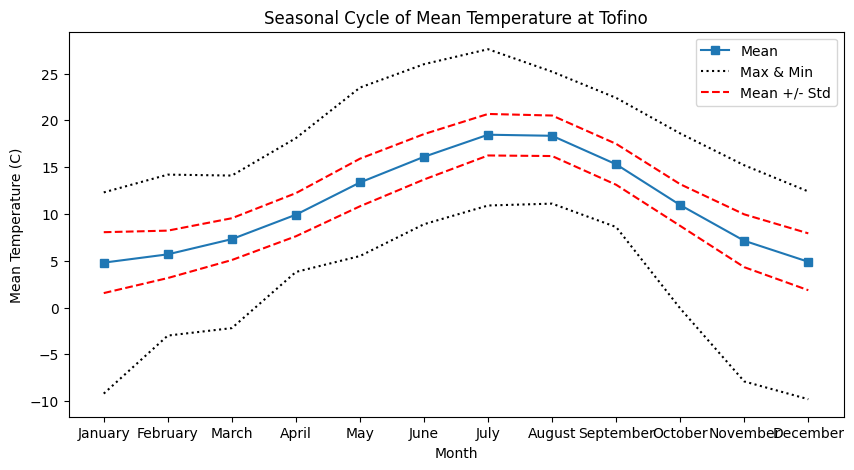

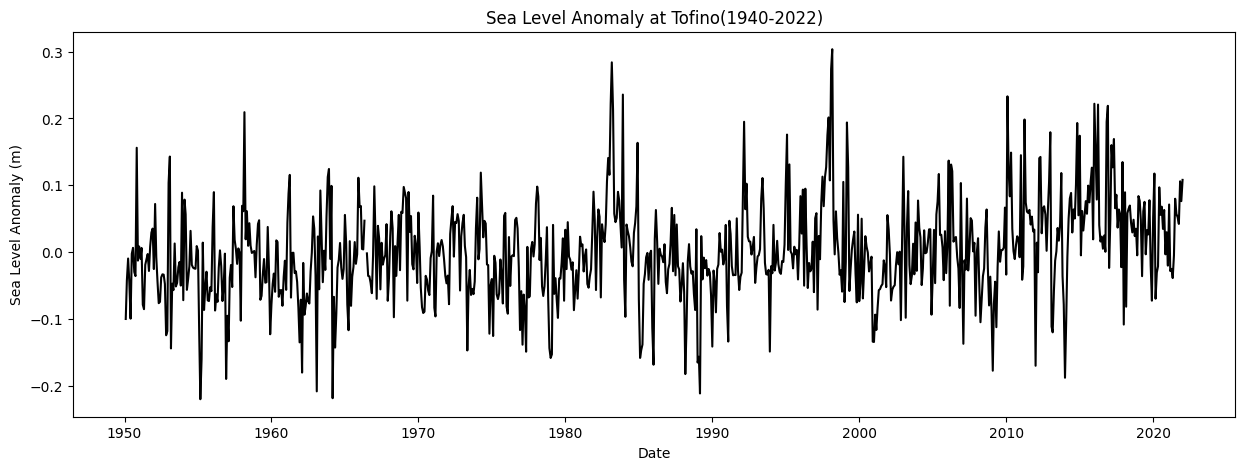

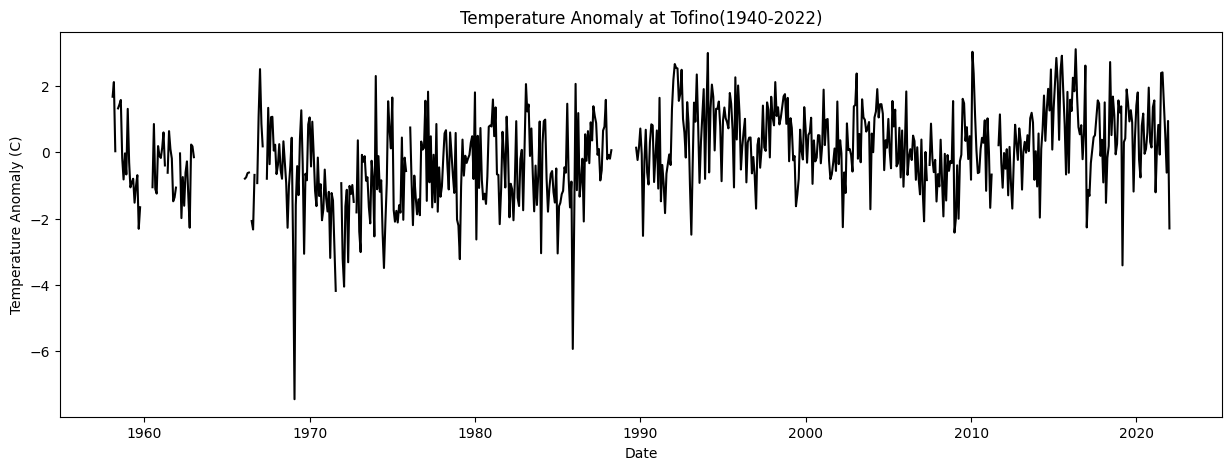

Coefficients: ', model.coef_
R^2:  0.09982647956211865


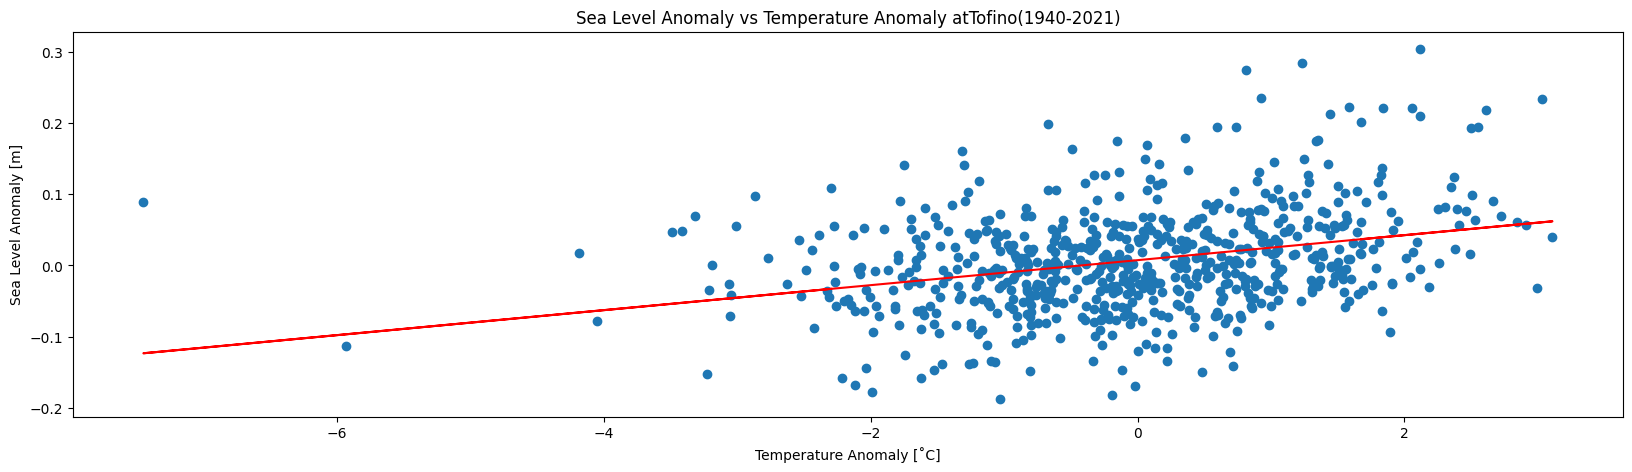

In [221]:
plot_all(df_SOB_van, 'Vancouver Harbour')
plot_all(df_SOB_tofino, 'Tofino')